In [1]:
# ================================
# IMPORTS & SETUP
# ================================
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
import numpy as np
from sklearn.preprocessing import label_binarize
from collections import Counter

# Set matplotlib to display inline in Kaggle
%matplotlib inline

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    torch.backends.cudnn.benchmark = True

print("="*60)
print("INCEPTION V1 TRANSFER LEARNING - WEATHER CLASSIFICATION")
print("="*60)

Device: cuda
GPU: Tesla P100-PCIE-16GB
INCEPTION V1 TRANSFER LEARNING - WEATHER CLASSIFICATION


In [2]:
# ================================
# 1) DATASET LOADING & ANALYSIS
# ================================
print("\n" + "="*60)
print("1. DATASET LOADING & ANALYSIS")
print("="*60)

data_dir = "/kaggle/input/5class-weather-status-image-classification/data"
print(f"Data path: {data_dir}")
print(f"Path exists: {os.path.exists(data_dir)}")

if os.path.exists(data_dir):
    print(f"Contents: {os.listdir(data_dir)}")
    
    # Check inner structure
    if os.path.exists(os.path.join(data_dir, "data")):
        data_dir = os.path.join(data_dir, "data")
        print(f"Using inner data folder: {data_dir}")


1. DATASET LOADING & ANALYSIS
Data path: /kaggle/input/5class-weather-status-image-classification/data
Path exists: True
Contents: ['sunny', 'cloudy', 'snowy', 'foggy', 'rainy']


In [3]:
# ================================
# 2) DATA TRANSFORMS WITH AUGMENTATION
# ================================
print("\n" + "="*60)
print("2. DATA TRANSFORMS & AUGMENTATION")
print("="*60)

# Augmentation for training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Simple transforms for validation
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
try:
    full_ds = datasets.ImageFolder(data_dir, transform=train_transforms)
    classes = full_ds.classes
    num_classes = len(classes)
    print(f"✓ Dataset loaded successfully!")
    print(f"  Classes: {classes}")
    print(f"  Total samples: {len(full_ds)}")
except Exception as e:
    print(f"✗ Error loading dataset: {e}")
    raise


2. DATA TRANSFORMS & AUGMENTATION
✓ Dataset loaded successfully!
  Classes: ['cloudy', 'foggy', 'rainy', 'snowy', 'sunny']
  Total samples: 18038



3. DATASET DISTRIBUTION & SAMPLE VISUALIZATION

Class Distribution:
----------------------------------------
Class           Count      Percentage
----------------------------------------
cloudy          6702       37.2%
foggy           1260       7.0%
rainy           1927       10.7%
snowy           1875       10.4%
sunny           6274       34.8%

Dataset imbalance ratio: 5.32
⚠️  Warning: Significant class imbalance detected!

Displaying sample images from each class...


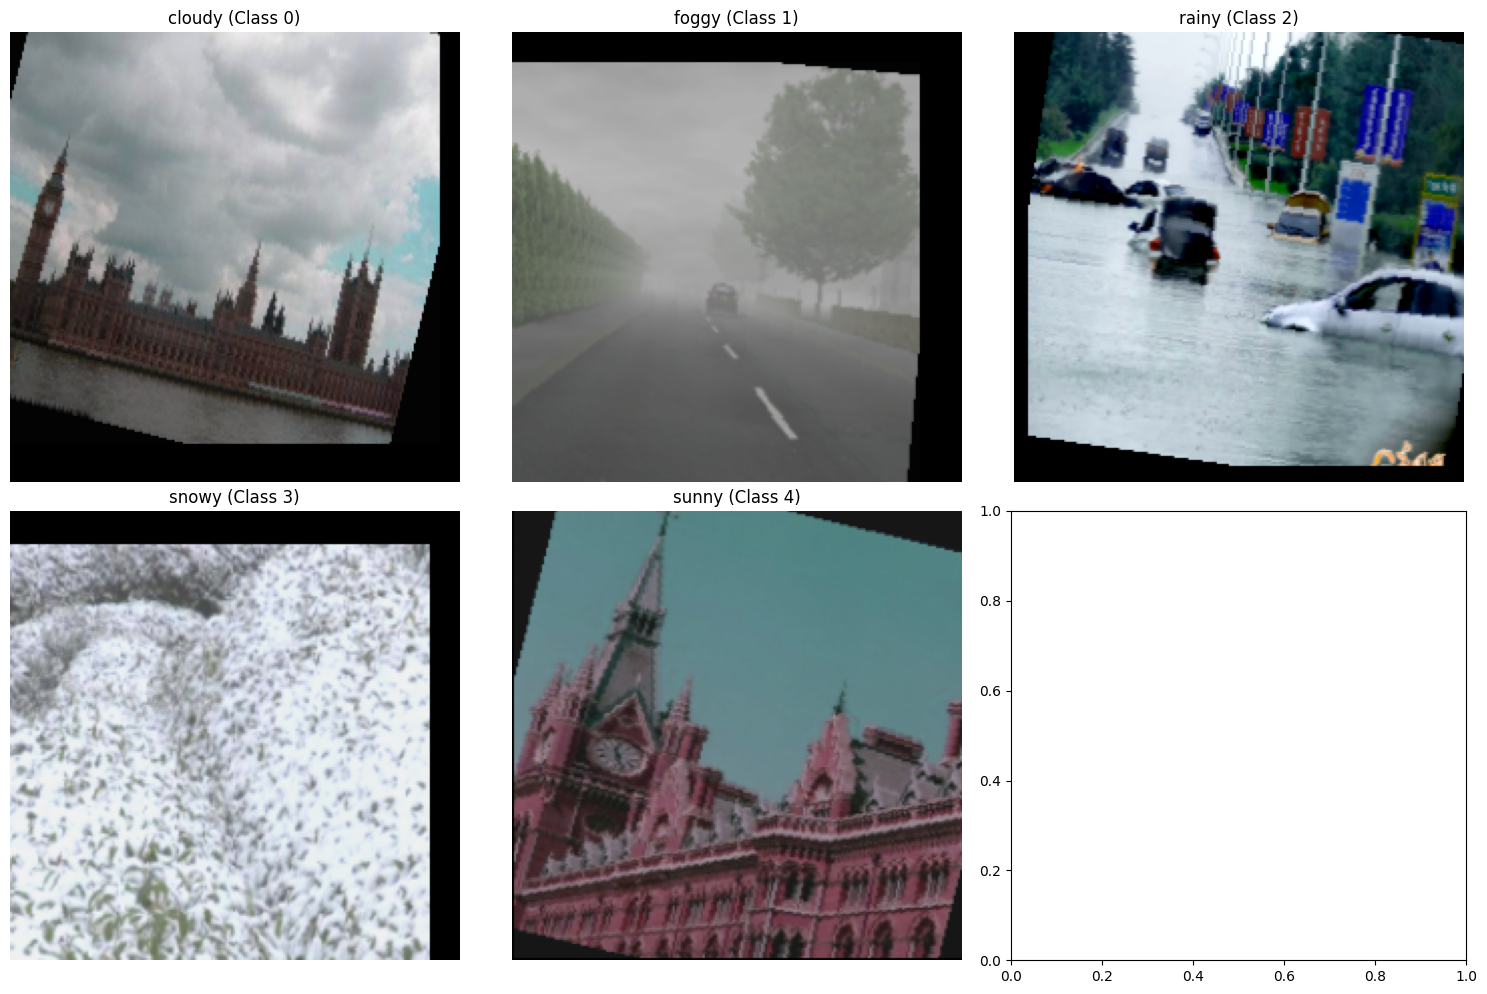

In [4]:
# ================================
# 3) DATASET DISTRIBUTION & VISUALIZATION
# ================================
print("\n" + "="*60)
print("3. DATASET DISTRIBUTION & SAMPLE VISUALIZATION")
print("="*60)

# Calculate class distribution
class_counts = {}
class_indices = {cls: [] for cls in classes}

for idx, (_, label) in enumerate(full_ds):
    class_name = classes[label]
    class_counts[class_name] = class_counts.get(class_name, 0) + 1
    class_indices[class_name].append(idx)

print("\nClass Distribution:")
print("-"*40)
print(f"{'Class':<15} {'Count':<10} {'Percentage':<10}")
print("-"*40)

for class_name in classes:
    count = class_counts[class_name]
    percentage = (count / len(full_ds)) * 100
    print(f"{class_name:<15} {count:<10} {percentage:.1f}%")

# Check for imbalance
max_count = max(class_counts.values())
min_count = min(class_counts.values())
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"\nDataset imbalance ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 3:
    print("⚠️  Warning: Significant class imbalance detected!")

# Display sample images
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Convert normalized tensor back to image"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

print("\nDisplaying sample images from each class...")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, class_name in enumerate(classes):
    if idx >= 6:  # Only show 6 classes max
        break
    
    # Get first sample for this class
    if class_indices[class_name]:
        sample_idx = class_indices[class_name][0]
        img, label = full_ds[sample_idx]
        
        # Denormalize for display
        img_denorm = denormalize(img)
        img_np = img_denorm.numpy().transpose(1, 2, 0)
        img_np = np.clip(img_np, 0, 1)
        
        axes[idx].imshow(img_np)
        axes[idx].set_title(f"{class_name} (Class {label})", fontsize=12)
        axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [5]:
# ================================
# 4) DATA SPLITTING & LOADERS (FIXED)
# ================================
print("\n" + "="*60)
print("4. DATA SPLITTING & LOADER PREPARATION (FIXED)")
print("="*60)

# خيار 1: تقسيم مباشر بدون sampler مشاكل
train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size

# Use stratified split instead
from sklearn.model_selection import train_test_split

# Get all indices
indices = list(range(len(full_ds)))
labels = [label for _, label in full_ds]

# Stratified split
train_indices, val_indices = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42
)

# Create subsets
from torch.utils.data import Subset
train_ds = Subset(full_ds, train_indices)
val_ds = Subset(full_ds, val_indices)

# Apply validation transforms to validation set
# Create a custom dataset that applies different transforms
class TransformedSubset(Subset):
    def __init__(self, dataset, indices, transform=None):
        super().__init__(dataset, indices)
        self.transform = transform
    
    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label

# Apply val transforms to validation set
val_ds = TransformedSubset(full_ds, val_indices, transform=val_transforms)

print(f"Training samples: {len(train_ds)} ({len(train_ds)/len(full_ds)*100:.1f}%)")
print(f"Validation samples: {len(val_ds)} ({len(val_ds)/len(full_ds)*100:.1f}%)")

# Create data loaders WITHOUT sampler
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

print("✓ Data loaders created successfully!")



4. DATA SPLITTING & LOADER PREPARATION (FIXED)
Training samples: 14430 (80.0%)
Validation samples: 3608 (20.0%)
✓ Data loaders created successfully!


In [6]:
# ================================
# 5) INCEPTION V1 MODEL SETUP (SIMPLIFIED)
# ================================
print("\n" + "="*60)
print("5. INCEPTION V1 MODEL SETUP (SIMPLIFIED)")
print("="*60)

# Load pre-trained Inception V1
print("Loading pre-trained Inception V1 (GoogLeNet)...")
try:
    weights = models.GoogLeNet_Weights.IMAGENET1K_V1
    model = models.googlenet(weights=weights, aux_logits=True)
    print("✓ Pre-trained model loaded")
except:
    # Fallback if download fails
    print("Using model without pre-trained weights...")
    model = models.googlenet(weights=None, aux_logits=True)

model.to(device)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last few layers
print("\nUnfreezing specific layers for fine-tuning...")
layers_to_train = ['inception4d', 'inception4e', 'inception5a', 'inception5b', 'fc']

for name, param in model.named_parameters():
    if any(layer_name in name for layer_name in layers_to_train):
        param.requires_grad = True
        # print(f"  Training: {name}")

# Replace final classifier
print(f"Replacing final classifier for {num_classes} classes...")
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)
model.fc.to(device)

# Calculate parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Summary:")
print(f"  • Total parameters: {total_params:,}")
print(f"  • Trainable parameters: {trainable_params:,}")
print(f"  • Fine-tuning {trainable_params/total_params*100:.1f}% of model")

# Loss function with class weights for imbalance
print("\nSetting up loss function...")
if imbalance_ratio > 2:
    # Calculate inverse frequency weights
    class_weights = []
    total_samples = sum(class_counts.values())
    
    for class_name in classes:
        weight = total_samples / (len(classes) * class_counts[class_name])
        class_weights.append(weight)
    
    class_weights = torch.FloatTensor(class_weights).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    print("✓ Using weighted CrossEntropyLoss")
else:
    criterion = nn.CrossEntropyLoss()

# Optimizer
print("Setting up optimizer...")
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.0001,
    weight_decay=1e-4
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

print("✓ Training setup complete")


5. INCEPTION V1 MODEL SETUP (SIMPLIFIED)
Loading pre-trained Inception V1 (GoogLeNet)...


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 169MB/s] 
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


✓ Pre-trained model loaded

Unfreezing specific layers for fine-tuning...
Replacing final classifier for 5 classes...

Model Summary:
  • Total parameters: 12,243,573
  • Trainable parameters: 10,213,173
  • Fine-tuning 83.4% of model

Setting up loss function...
✓ Using weighted CrossEntropyLoss
Setting up optimizer...
✓ Training setup complete


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
# ================================
# 6) FIXED TRAINING FUNCTION
# ================================
print("\n" + "="*60)
print("6. STARTING TRAINING")
print("="*60)

def train_epoch_simple(model, loader, criterion, optimizer, device):
    """Simple training function without auxiliary losses"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass - disable aux losses to avoid issues
        outputs = model(images)
        
        # Handle tuple output (main, aux1, aux2)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Take only main output
        
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Statistics
        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Progress update
        if (batch_idx + 1) % 20 == 0:
            print(f'  Batch {batch_idx+1}/{len(loader)}, Loss: {loss.item():.4f}')
    
    epoch_loss = total_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_simple(model, loader, criterion, device):
    """Simple validation function"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            # Handle tuple output
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = total_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

def train_model_simple(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                       epochs=15, patience=5, device='cuda'):
    """Main training loop - simplified"""
    print(f"Starting training for {epochs} epochs...")
    print("-"*60)
    
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    best_val_acc = 0.0
    counter = 0
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print("-"*40)
        
        # Training
        train_loss, train_acc = train_epoch_simple(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        
        # Validation
        val_loss, val_acc, val_preds, val_labels = validate_simple(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
                'classes': classes
            }, '/kaggle/working/best_model.pth')
            print(f"✓ Saved best model (Acc: {val_acc:.2f}%)")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"\nEarly stopping at epoch {epoch + 1}")
                break
    
    print("\n" + "="*60)
    print("TRAINING COMPLETED")
    print("="*60)
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    
    return train_losses, train_accs, val_losses, val_accs

# Start training with fewer epochs for testing
epochs = 10  # Start with 10 epochs
print(f"\nTraining for {epochs} epochs...")
train_losses, train_accs, val_losses, val_accs = train_model_simple(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    epochs=epochs, patience=3, device=device
)


6. STARTING TRAINING

Training for 10 epochs...
Starting training for 10 epochs...
------------------------------------------------------------

Epoch 1/10
----------------------------------------
  Batch 20/451, Loss: 1.5931
  Batch 40/451, Loss: 1.4428
  Batch 60/451, Loss: 1.4023
  Batch 80/451, Loss: 1.3476
  Batch 100/451, Loss: 1.3138
  Batch 120/451, Loss: 1.0452
  Batch 140/451, Loss: 1.1017
  Batch 160/451, Loss: 0.7618
  Batch 180/451, Loss: 1.1701
  Batch 200/451, Loss: 0.7673
  Batch 220/451, Loss: 0.7383
  Batch 240/451, Loss: 0.5415
  Batch 260/451, Loss: 0.7491
  Batch 280/451, Loss: 0.6996
  Batch 300/451, Loss: 0.4712
  Batch 320/451, Loss: 0.8985
  Batch 340/451, Loss: 0.3799
  Batch 360/451, Loss: 0.7061
  Batch 380/451, Loss: 0.4349
  Batch 400/451, Loss: 0.5150
  Batch 420/451, Loss: 1.0226
  Batch 440/451, Loss: 0.5871
Train - Loss: 0.9035, Acc: 61.90%
Val   - Loss: 0.5434, Acc: 77.27%
✓ Saved best model (Acc: 77.27%)

Epoch 2/10
---------------------------------


7. TRAINING VISUALIZATION


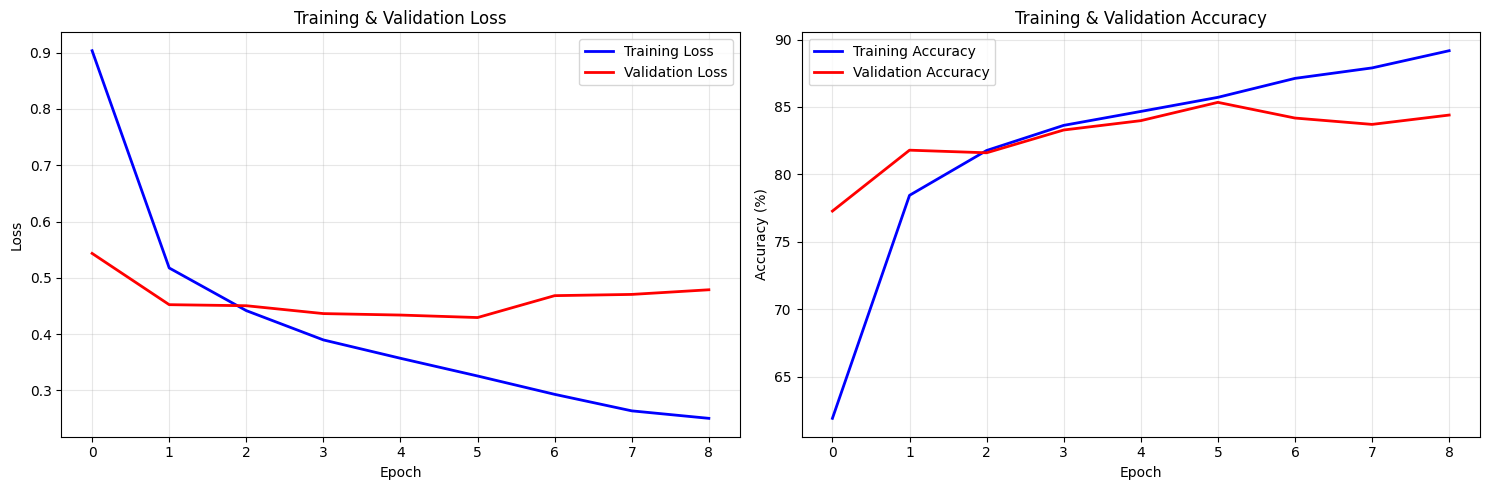

In [8]:

# ================================
# 7) TRAINING VISUALIZATION
# ================================
print("\n" + "="*60)
print("7. TRAINING VISUALIZATION")
print("="*60)

if train_losses and val_losses:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    axes[0].plot(train_losses, 'b-', label='Training Loss', linewidth=2)
    axes[0].plot(val_losses, 'r-', label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training & Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy plot
    axes[1].plot(train_accs, 'b-', label='Training Accuracy', linewidth=2)
    axes[1].plot(val_accs, 'r-', label='Validation Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training & Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No training data to visualize")


8. MODEL EVALUATION
Loading best model for evaluation...
Loaded model from epoch 5 with accuracy 85.34%

Classification Report:
              precision    recall  f1-score   support

      cloudy       0.86      0.79      0.82      1341
       foggy       0.79      0.92      0.85       252
       rainy       0.82      0.79      0.80       385
       snowy       0.82      0.88      0.85       375
       sunny       0.84      0.88      0.86      1255

    accuracy                           0.84      3608
   macro avg       0.82      0.85      0.84      3608
weighted avg       0.84      0.84      0.84      3608


Confusion Matrix:
[[1055   25   38   32  191]
 [  11  231    5    2    3]
 [  30   17  303   28    7]
 [   9   11   18  330    7]
 [ 124   10    7   11 1103]]


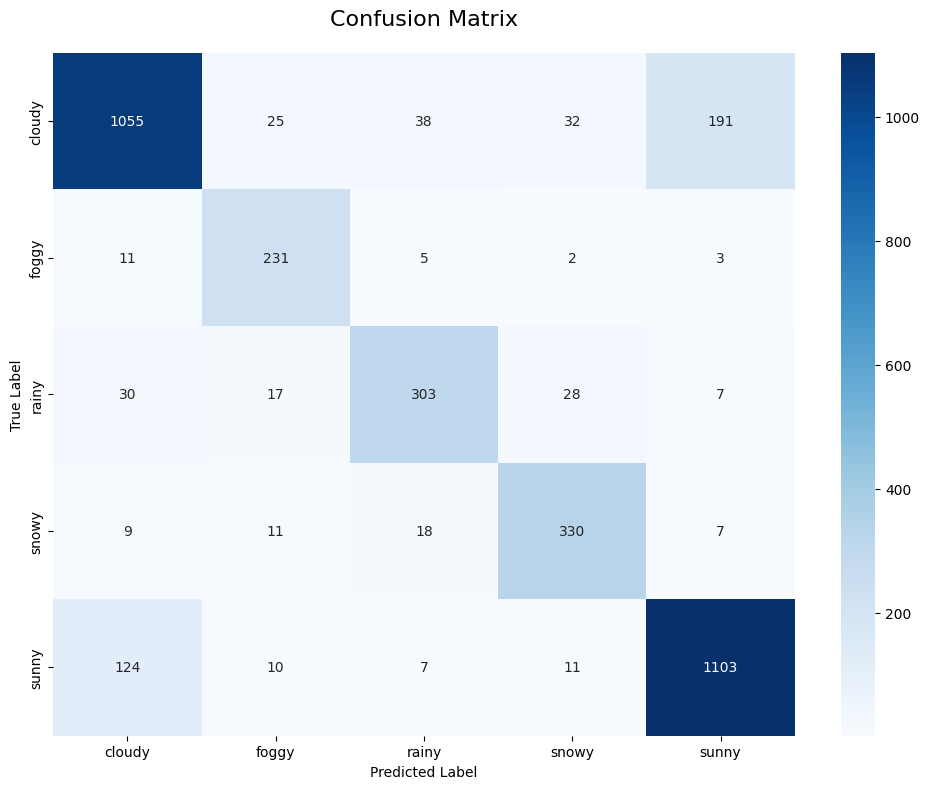


Overall Accuracy: 83.76%

9. ROC CURVES & AUC SCORES


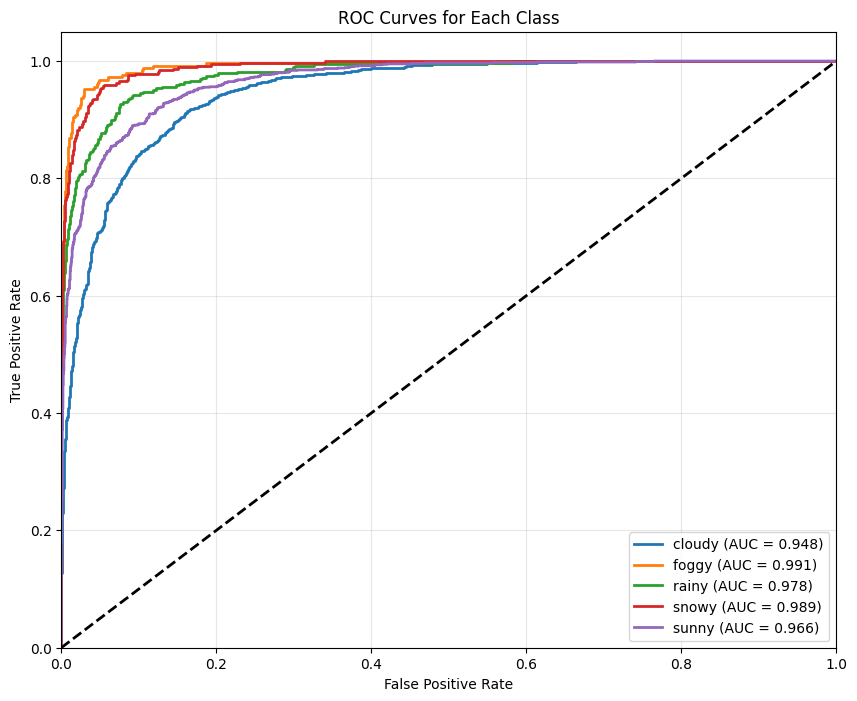


AUC Scores:
  cloudy: 0.9483
  foggy: 0.9911
  rainy: 0.9776
  snowy: 0.9894
  sunny: 0.9663


In [9]:
# ================================
# 8) EVALUATION
# ================================
print("\n" + "="*60)
print("8. MODEL EVALUATION")
print("="*60)

# Load best model
if os.path.exists('/kaggle/working/best_model.pth'):
    print("Loading best model for evaluation...")
    checkpoint = torch.load('/kaggle/working/best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from epoch {checkpoint['epoch']} with accuracy {checkpoint['val_acc']:.2f}%")
else:
    print("Using current model for evaluation...")

# Get predictions
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        
        # Handle tuple output
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        
        probs = torch.softmax(outputs, dim=1)
        _, preds = outputs.max(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Classification report
print("\nClassification Report:")
print("="*60)
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix', fontsize=16, pad=20)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Calculate accuracy
accuracy = np.mean(all_preds == all_labels)
print(f"\nOverall Accuracy: {accuracy*100:.2f}%")

# ================================
# 9) ROC CURVES
# ================================
print("\n" + "="*60)
print("9. ROC CURVES & AUC SCORES")
print("="*60)

# Binarize labels
y_true_bin = label_binarize(all_labels, classes=range(num_classes))
y_score = all_probs

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Calculate macro AUC
print("\nAUC Scores:")
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"  {class_name}: {roc_auc:.4f}")

In [10]:
# ================================
# 10) SAVE FINAL MODEL
# ================================
print("\n" + "="*60)
print("10. SAVING FINAL MODEL")
print("="*60)

# Save final model
final_model_path = '/kaggle/working/inception_v1_weather_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'classes': classes,
    'accuracy': accuracy,
    'transform': val_transforms,
    'imbalance_ratio': imbalance_ratio
}, final_model_path)

print(f"✓ Model saved to: {final_model_path}")
print(f"✓ Model accuracy: {accuracy*100:.2f}%")
print(f"✓ Classes: {classes}")

# Save evaluation results
results = {
    'classes': classes,
    'all_labels': all_labels,
    'all_preds': all_preds,
    'all_probs': all_probs,
    'confusion_matrix': cm,
    'accuracy': accuracy,
    'training_history': {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs
    }
}

torch.save(results, '/kaggle/working/evaluation_results.pth')
print("✓ Evaluation results saved")



10. SAVING FINAL MODEL
✓ Model saved to: /kaggle/working/inception_v1_weather_model.pth
✓ Model accuracy: 83.76%
✓ Classes: ['cloudy', 'foggy', 'rainy', 'snowy', 'sunny']
✓ Evaluation results saved


In [11]:
# ================================
# 11) FINAL SUMMARY
# ================================
print("\n" + "="*60)
print("PROJECT SUMMARY")
print("="*60)
print(f"\nDataset: Weather Classification")
print(f"Classes: {len(classes)} classes")
print(f"Total samples: {len(full_ds)}")
print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Class imbalance ratio: {imbalance_ratio:.2f}")
print(f"\nModel: Inception V1 (GoogLeNet)")
print(f"Training approach: Transfer Learning")
print(f"Fine-tuned layers: Last 2 Inception blocks + classifier")
print(f"Final validation accuracy: {accuracy*100:.2f}%")
print(f"\nFiles saved in /kaggle/working/:")
print("  • best_model.pth - Best model during training")
print("  • inception_v1_weather_model.pth - Final model")
print("  • evaluation_results.pth - All evaluation metrics")
print("\n✅ Project completed successfully!")

# Show file sizes
import os
print("\nFile sizes:")
for file in ['best_model.pth', 'inception_v1_weather_model.pth', 'evaluation_results.pth']:
    path = f'/kaggle/working/{file}'
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024*1024)
        print(f"  {file}: {size_mb:.2f} MB")


PROJECT SUMMARY

Dataset: Weather Classification
Classes: 5 classes
Total samples: 18038
Training samples: 14430
Validation samples: 3608
Class imbalance ratio: 5.32

Model: Inception V1 (GoogLeNet)
Training approach: Transfer Learning
Fine-tuned layers: Last 2 Inception blocks + classifier
Final validation accuracy: 83.76%

Files saved in /kaggle/working/:
  • best_model.pth - Best model during training
  • inception_v1_weather_model.pth - Final model
  • evaluation_results.pth - All evaluation metrics

✅ Project completed successfully!

File sizes:
  best_model.pth: 77.21 MB
  inception_v1_weather_model.pth: 46.89 MB
  evaluation_results.pth: 0.15 MB
